# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

#### 1.1. Importing the Data

We first import the relevant packages.

In [2]:
import glob
import pandas as pd
import numpy as np
from datetime import datetime
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

We then import the files of the three countries each in a `Dataframe`.

In [3]:
def import_data(country):
    """Returns Dataframe resulting from concatenation of files for given country"""
    file_list = glob.glob('Data/ebola/{}_data/*.csv'.format(country))
    return pd.concat([pd.read_csv(file_) for file_ in file_list])

guinea = import_data("guinea")
liberia = import_data("liberia")
sl = import_data("sl")

#### 1.2. Finding Data Correspondences

Reading the different dataframes, we see that there are five categories of interest if we want to get the daily average per month of **new** cases and deaths.

In [4]:
CASES_SUSPECTS = "New Cases: Suspects"
CASES_PROBABLES = "New Cases: Probables"
CASES_CONFIRMED = "New Cases: Confirmed"
CASES_TOTAL = "New Cases: Total"
DEATHS_TOTAL = "New Deaths: Total"

Then, we can map the correspondences from the files to these categories in the following functions.

In [5]:
def label_guinea(description):
    try:
        return {"New cases of suspects": CASES_SUSPECTS,
                "New cases of probables": CASES_PROBABLES,
                "New cases of confirmed": CASES_CONFIRMED,
                "Total new cases registered so far": CASES_TOTAL,
                "New deaths registered today": DEATHS_TOTAL,
                "New deaths registered": DEATHS_TOTAL}[description]
    except:
        return None

def label_liberia(description):
    try:
        return {"New Case/s (Suspected)": CASES_SUSPECTS,
                "New Case/s (Probable)": CASES_PROBABLES,
                "New case/s (confirmed)": CASES_CONFIRMED,
                "Newly reported deaths": DEATHS_TOTAL}[description]
    except:
        return None

def label_sl(description):
    try:
        return {"new_suspected": CASES_SUSPECTS,
                "new_probable": CASES_PROBABLES,
                "new_confirmed": CASES_CONFIRMED,
                "etc_new_deaths": DEATHS_TOTAL}[description]
    except:
        return None

#### 1.3. Exploiting and Merging the Data

We first establish a function that gives the `DataFrame` corresponding to each country's data summary: it contains the daily average per month and per year of new cases and deaths.

In [6]:
def get_summary_dataframe(data, country, number_column, text_column, date_column, label_function):
    """
    Gives DataFrame containing the daily average per month and per year of the given country's new cases and deaths.
    :param data: DataFrame containing the imported data from files
    :param country: string, name of the country
    :param number_column: string, name of the column containing the numbers to be averaged
    :param text_column: string, name of the column containing the description of the numbers given
    :param date_column: string, name of the column containing the date of the record
    :param label_function: function, corresponding to function mapping files to data categories
    :return: DataFrame
    """
    df_copy = data.copy()
    
    # Applying the mapping and filtering
    df_copy[text_column] = df_copy[text_column].apply(label_function)
    df_copy = df_copy[(df_copy[text_column].notnull())]
    
    # Filtering the columns
    df = df_copy[[text_column, number_column]]
    
    # Making sure all of the data in the number column are interpreted as integers, with NaNs replaced by zero
    df[number_column] = df[number_column].fillna(0).apply(int)
    
    # Renaming the column corresponding to text_column
    df["Daily Average"] = df[text_column].rename("Daily Average")
    
    # Adding Country Column
    df['Country'] = pd.Series([country] * len(df), index=df.index)
    
    # Adding columns to split the Date
    df['Year'] = pd.DatetimeIndex(df_copy[date_column]).year
    df['Month'] = pd.DatetimeIndex(df_copy[date_column]).month
    df['Day'] = pd.DatetimeIndex(df_copy[date_column]).day
    
    # Reshaping the DataFrame
    df = df.set_index(["Daily Average", "Country", 'Year', 'Month', 'Day'])[number_column].unstack("Daily Average")
    
    # Averaging
    df = df.mean(level=[0,1,2])
    return df

By reading the columns of the `DataFrame` instances, we can establish the names of the columns of interest. Then, we use the function above to get the summary data frames and we concatenate them. The result is shown below.

In [7]:
df_guinea = get_summary_dataframe(guinea, "Guinea", "Totals", "Description", "Date", label_guinea)
df_liberia = get_summary_dataframe(liberia, "Liberia", "National", "Variable", "Date", label_liberia)
df_sl = get_summary_dataframe(sl, "Sierra Leone", "National", "variable", "date", label_sl)
pd.concat([df_guinea, df_liberia, df_sl])

New Cases: Confirmed  New Cases: Probables  \
Country      Year Month                                               
Guinea       2014 8                 12.400000              1.600000   
                  9                 13.000000              1.187500   
                  10                 6.000000              0.000000   
Liberia      2014 6                  2.142857              1.142857   
                  7                  1.818182              3.727273   
                  8                  5.444444             19.777778   
                  9                  6.166667             29.333333   
                  10                 1.360000             17.760000   
                  11                 2.600000              7.000000   
                  12              1928.333333           1208.000000   
Sierra Leone 2014 8                 18.550000              1.150000   
                  9                 34.413793              0.000000   
                  10                56.714286              0.857143   
                  11                59.904762              0.000000   
                  12                32.600000              0.000000   

                         New Cases: Suspects  New Cases: Total  \
Country      Year Month                                          
Guinea       2014 8                11.800000            25.800   
                  9                 5.437500            19.625   
                  10               28.000000            34.000   
Liberia      2014 6                 2.428571               NaN   
                  7                 3.000000               NaN   
                  8                12.000000               NaN   
                  9                28.333333               NaN   
                  10               26.440000               NaN   
                  11               16.866667               NaN   
                  12             2042.222222               NaN   
Sierra Leone 2014 8                 5.450000               NaN   
                  9                 6.275862               NaN   
                  10               13.357143               NaN   
                  11               15.333333               NaN   
                  12                8.400000               NaN   

                         New Deaths: Total  
Country      Year Month                     
Guinea       2014 8               3.400000  
                  9               3.562500  
                  10             15.000000  
Liberia      2014 6               2.000000  
                  7               4.272727  
                  8              23.222222  
                  9              36.041667  
                  10             28.040000  
                  11             13.466667  
                  12              0.000000  
Sierra Leone 2014 8               0.000000  
                  9               0.275862  
                  10              3.535714  
                  11              0.571429  
                  12              2.200000

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

#### 2.1. Importing the Data

We first import the nine spreadsheets into a single `DataFrame`.

In [8]:
# Folder path and list of file paths to import
path = 'Data/microbiome/'
all_files = glob.glob(path +  "MID*.xls")

# Iterating over the files
microbiome_dfs = []
for file in all_files:
    microbiome_file = pd.read_excel(file, header=None)
    microbiome_file['BARCODE'] = file.split(path)[1].split(".")[0]
    microbiome_dfs.append(microbiome_file)

# Concatenate the data frames
microbiome = pd.concat(microbiome_dfs, ignore_index = True)

# Preview
microbiome.head()

,0,1,BARCODE
0,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",7,MID1
1,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,MID1
2,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",3,MID1
3,"Archaea ""Crenarchaeota"" Thermoprotei Thermopro...",3,MID1
4,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",7,MID1


Then, we import the metadata file.

In [9]:
metadata = pd.read_excel(path + 'metadata.xls')
metadata.head()

,BARCODE,GROUP,SAMPLE
0,MID1,EXTRACTION CONTROL,NaN
1,MID2,NEC 1,tissue
2,MID3,Control 1,tissue
3,MID4,NEC 2,tissue
4,MID5,Control 2,tissue


#### 2.2. Merging the Data

We first merge the two `DataFrame` instances from above and fill the `NaN` values with the `unknown` tag. Then, we set up a unique index.

In [10]:
# Merging and Filling in NaN values
merged_df = pd.merge(microbiome, metadata).fillna('unknown')

# Renaming columns and setting indexes
merged_df = merged_df.rename(columns={0: 'TAXON', 1: 'COUNT'})
merged_df = merged_df.set_index(['BARCODE', 'TAXON'])[['GROUP', 'SAMPLE', 'COUNT']]

# Preview
merged_df.head()

GROUP  \
BARCODE TAXON                                                                    
MID1    Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  EXTRACTION CONTROL   
        Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  EXTRACTION CONTROL   
        Archaea "Crenarchaeota" Thermoprotei Sulfolobal...  EXTRACTION CONTROL   
        Archaea "Crenarchaeota" Thermoprotei Thermoprot...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...  EXTRACTION CONTROL   

                                                             SAMPLE  COUNT  
BARCODE TAXON                                                               
MID1    Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown      7  
        Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown      2  
        Archaea "Crenarchaeota" Thermoprotei Sulfolobal...  unknown      3  
        Archaea "Crenarchaeota" Thermoprotei Thermoprot...  unknown      3  
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...  unknown      7

We verify that the index is unique.

In [11]:
merged_df.index.is_unique

True

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [12]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

We first read the data from the Excel File.

In [13]:
titanic = pd.read_excel('Data/titanic.xls')
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


#### 3.1. Describe the type and the value range of each attribute. Indicate and transform the attributes that can be `Categorical`.

Hereafter, we describe the *type* of each attribute.

In [14]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1309 non-null int64
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 143.2+ KB


We describe the *value range* of each non-null numeric (`int64` or `float64`) attribute.

In [15]:
value_ranges = titanic.describe()
value_ranges.loc[["min", "max"]]

/Users/Khalil/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,pclass,survived,age,sibsp,parch,fare,body
min,1.0,0.0,0.1667,0.0,0.0,0.0000,1.0
max,3.0,1.0,80.0000,8.0,9.0,512.3292,328.0


We transform some `object` attributes to categorical, precisely those that take on only a limited, and usually fixed, number of possible values.

Cabin numbers have too many values to be considered categorical. Moreover, sometimes more than one cabin value can be attributed to one person, thereby increasing the number of possible combinations.

In [16]:
titanic['sex'] = titanic.sex.astype('category')
titanic['ticket'] = titanic.ticket.astype('category')
titanic['embarked'] = titanic.embarked.astype('category')
titanic['home.dest'] = titanic['home.dest'].astype('category')

#### 3.2. Plot histograms for the travel class, embarkation port, sex and age attributes. For the latter one, use discrete decade intervals.

Necessary imports.

In [17]:
import matplotlib.pyplot as plt
from matplotlib import cm

We make a function to plot histograms for each attribute.

In [18]:
def plot_histogram(attribute, attribute_name, dropna=False):
    # Computing values and labels (indexes)
    values = titanic[attribute].value_counts(dropna=dropna).sort_index()
    indexes = values.index
    y_pos = np.arange(len(indexes))
    # Bar plot
    plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, indexes)
    plt.xlabel(attribute_name)
    plt.ylabel('Number of travelers')
    plt.title('Number of travelers by {}'.format(attribute_name.lower()))
    plt.grid(axis='y')
    plt.show()

Histogram for the travel class attribute.

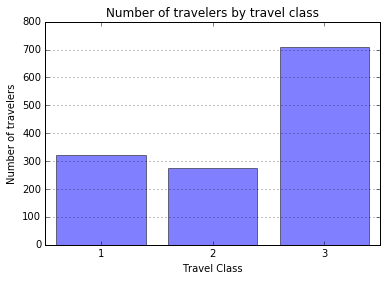

In [19]:
plot_histogram("pclass", "Travel Class")

Histogram for the embarkation port attribute.

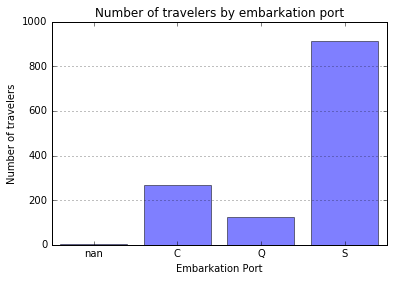

In [20]:
plot_histogram("embarked", "Embarkation Port")

Histogram for the sex attribute.

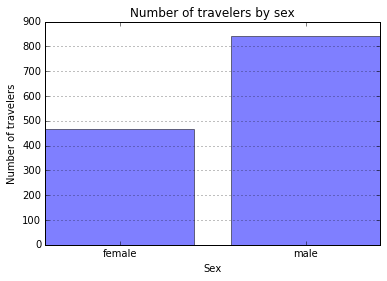

In [21]:
plot_histogram("sex", "Sex")

Histogram for the age attribute.

Here, we represent the ages by decade. First, we remove the `NaN` values, as well as negative ones which can be considered as errors. There is a minimum of 1 bin in the histogram.

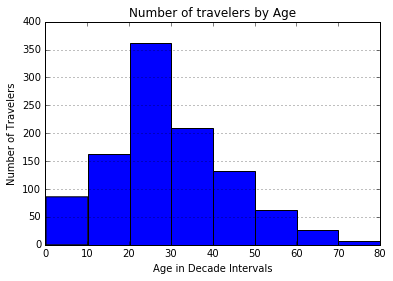

In [22]:
# Filtered Age Values
ages = titanic.age[titanic.age >= 0].dropna().values

# Number of bins
bins = max(1, int(np.ceil(max(ages)/10)))

# Histogram
plt.hist(ages, bins=bins, edgecolor='black')
plt.xlabel("Age in Decade Intervals")
plt.ylabel("Number of Travelers")
plt.title('Number of travelers by Age')
plt.grid(axis='y')
plt.show()

#### 3.3. Calculate the proportion of passengers by cabin floor. Present your results in a pie chart.

We make a function that, given a cabin cell, returns the same if it is `null` or the corresponding floor otherwise. In some cases, there were two floors marked: then we count the corresponding person only *once* and assign it to the (ordered) combination of floors they belong to.

In [23]:
def get_floor(cabin):
    if pd.isnull(cabin):
        return cabin
    else:
        return ''.join(sorted(set([character for character in cabin if character.isupper()])))

In [24]:
titanic["floor"] = titanic["cabin"]
titanic["floor"] = titanic["floor"].apply(get_floor).fillna("unknown")
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,floor
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",B
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",C
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",C
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",C
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",C


We compute the data to plot.

In [25]:
values = titanic.floor.value_counts().sort_index()
floor_idx = values.index
colors = cm.Set1(np.arange(len(values))/len(values))

We make a function that plot the pie charts.

In [26]:
def cabin_floor_pie_chart(values, floor_idx, extra_label=""):
    percentages = values*100.0/sum(values)
    labels = ['{0} - {1:1.2f} %'.format(floor_index, percentage) for floor_index, percentage in zip(floor_idx, percentages)]
    patches, _ = plt.pie(values, labels = floor_idx, colors = colors, counterclock=False)
    plt.legend(patches, labels, loc='best',fontsize=12, bbox_to_anchor=(0, 1))
    plt.title('Proportion of passengers by cabin floor{}'.format(extra_label))
    plt.show()

We plot the pie charts for passengers by cabin floor. Having noticed the large proportion of `unknown` floors, we also plot a pie chart excluding those values.

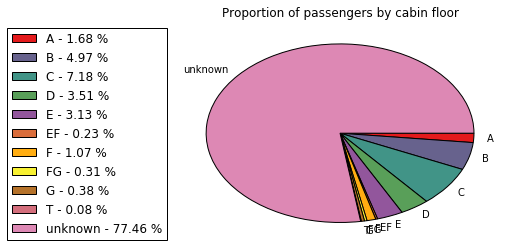

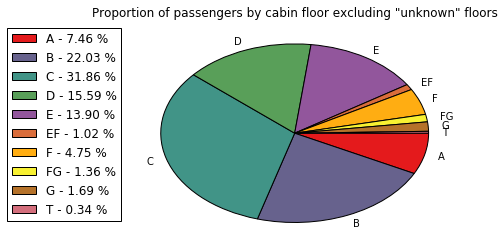

In [27]:
cabin_floor_pie_chart(values, floor_idx)
cabin_floor_pie_chart(values[:-1], floor_idx[:-1], ' excluding "unknown" floors')

#### 3.4. For each travel class, calculate the proportion of the passengers that survived. Present your results in pie charts.

We first make a function to compute the data for each class.

In [ ]:
def proportions_for_class(class_id):
    survivals = len(titanic[(titanic.pclass == class_id) & (titanic.survived == 1)])
    deaths = len(titanic[(titanic.pclass == class_id) & (titanic.survived == 0)])
    return [survivals, deaths]

Then a function to show a class' pie chart.

In [ ]:
def class_pie_chart(class_id, proportions):
    labels = 'Survived', 'Died'
    colors = ['gold', 'lightcoral']
    explode = (0.1, 0)  # explode 1st slice
 
    plt.title('Proportion of survivals in Class {}'.format(class_id))
    plt.pie(proportions, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
    plt.axis('equal')
    plt.show()

The pie charts are plotted.

In [ ]:
for class_id in [1,2,3]:
    class_pie_chart(class_id, proportions_for_class(class_id))

#### 3.5. Calculate the proportion of the passengers that survived by travel class and sex. Present your results in a single histogram.

We plot a histogram for survivals by travel class and sex. We group the survivals by travel class.

In [ ]:
# Computing the values
female_percentages = list(titanic[titanic.sex == "female"].groupby("pclass")["survived"].mean())
male_percentages = list(titanic[titanic.sex == "male"].groupby("pclass")["survived"].mean())
class_labels = ["Class {}".format(class_id) for class_id in titanic.pclass.unique()]

# Plotting the histogram
width = 0.35
y_pos = np.arange(len(class_labels))
plt.bar(y_pos-width/2, female_percentages, width=width, align='center', alpha=0.4, color='r', label="Female")
plt.bar(y_pos+width/2, male_percentages, width=width, align='center', alpha=0.4, label="Male")
plt.xticks(y_pos, class_labels)
plt.ylabel("Proportion")
plt.title('Proportion of the passengers that survived by travel class and sex')
axes = plt.gca()
axes.set_ylim([0,1])
plt.grid(axis='y')
plt.legend()
plt.show()

#### 3.6. Create 2 equally populated age categories and calculate survival proportions by age category, travel class and sex. Present your results in a `DataFrame` with unique index.

We compute the median for age in this date.

In [ ]:
age_median = np.median(titanic.age[titanic.age.notnull()])
age_median

We create 2 roughly equally populated age categories.

In [ ]:
equal_to_median = len(titanic.age[(titanic.age.notnull()) & (titanic.age == age_median)])
less_than_median = len(titanic.age[(titanic.age.notnull()) & (titanic.age < age_median)])
more_than_median = len(titanic.age[(titanic.age.notnull()) & (titanic.age > age_median)])
print("There are {} people aged 28. There are more people older than the median ({}) than younger ({}).".format(equal_to_median, more_than_median, less_than_median))
print("So the best split is a group of {} people that are 28 or younger, and one of {} people that are older than 28.".format(equal_to_median + less_than_median, more_than_median))

We create a function to map each person to its category. People with `NaN` values as age are grouped as a separate category. If `ignore_null` is set to `True`, they will not have a category and will be ignored.

In [ ]:
def categorise_by_age(age, ignore_null=False):
    if pd.isnull(age):
        if not ignore_null:
            return "Unknown age"
        else:
            return age
    elif age <= age_median:
        return "28 or younger"
    else:
        return "Older than 28"

We create a new column in the `titanic` `DataFrame`.

In [ ]:
titanic["age_category"] = titanic.age.apply(categorise_by_age)

We form the single `DataFrame` containing the survival proportions by age category, travel class and sex.

In [ ]:
age_category_df = pd.DataFrame(titanic.groupby(["age_category","pclass", "sex"])["survived"].mean())
age_category_df

We verify that the index of this `DataFrame` is unique.

In [ ]:
age_category_df.index.is_unique